# Basic End-to-End Test

Bobby Pascua, Steven Murray, Nick Kern, Jacob Burba, Josh Dillon, and the HERA Validation Team

## Setup and Metadata

### Abstract

This test combines the processes and knowledge built up over Steps -1 through 3 into an integrated test of the end-to-end pipeline, at a basic level. In particular, this tests each pipeline component *under its own ideal assumptions*. Furthermore, it does *not* test the `xrfi` component. 

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import copy
import glob
import sys
import pathlib
from collections import defaultdict

import astropy
import astropy.units as units
import h5py

import hera_cal
import hera_pspec
import pyuvdata
import uvtools

from pyuvdata import UVData, UVBeam
from hera_cal import io
from hera_pspec.data import DATA_PATH as PSPEC_DATA_PATH

sys.path.append("../../")
import template_tools

### Description

In [2]:
print(f'Last executed: {str(datetime.now())}')

Last executed: 2020-03-26 21:02:30.382340


- **Major Step Description:** Simulate all components of a realistic observation, and enact an analysis pipeline in the same way as for a real IDR.
- **Minor Variation Description:** 
  - EoR: $P(k) = A_0 k^{-2}$ (amplified, frequency dependent) simulated with `RIMEz`. (ala `0.2.0`)
  - FG: GLEAM + eGSM + brights, simulated with `RIMEz` (ala `1.2.0`)
  - Sky Simulation Format: 
    - Idealized H1C Antenna positions (perfect redundancy)
    - Identical Fagnoni beam applied to each baseline.
    - Full frequency coverage of H1C
    - Times of observation rephased from original LSTs to match 10 chosen days of H1C IDR2.2, for 6 hours per day.
  - Systematics (in order of application):
    - Thermal noise from autocorrelations using `hera_sim`.
    - Gains (linear drift with time, repeating per night) from `hera_sim` (ala `2.1.0`)
    - Cable reflections from `hera_sim` (ala `3.2.0`).
    - Cross-coupling from `hera_sim` (ala `3.2.0`).
  - RFI *flags* applied to post-calibrated data (ala `3.1.0`). Flags drawn from the matched 10 days of actual H1C IDR2.2 data.
- **Pipelines Tested:** `firstcal`, `redcal`, `abscal`, `smoothcal`, `in-painting` `systematics_removal`, `pspec`
- **Criteria**:
  1. Residuals to averaged input EoR-only P(k) within 1% on scales of interest.

### Software

In [3]:
template_tools.print_dep_versions(extras=['astropy', 'hera_cal'], ignore=['healvis'])

Module pyuvdata   ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46
Module hera_stats ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46


/users/rpascua/hera_packages/hera_sim/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


Module hera_sim   ....	Version 0.1.0  .......	Git b'6cd21e2684867d90c2105d4287718a97af9767c4'
Module hera_qm    ....	Version 1.0    .......	Git 597ec3b498ce1b30cbef2736df1addfc4a6b9ffe
Module hera_pspec ....	Version 0.2.0  .......	Git dad85a51adb57501dc24081cd7ea9687cf512e7c
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git b931bc98a92132a49dc4a2c0421396d3cd59a063
Module numpy      ....	Version 1.17.4 .......	Git None
Module healpy     ....	Version 1.12.9 .......	Git None
Module h5py       ....	Version 2.9.0  .......	Git None
Module astropy    ....	Version 4.0    .......	Git None
Module hera_cal   ....	Version 2.0    .......	Git 2e5dd382872f649266f334e9f3ded4fc4803f017


### Data

The data directly used in this notebook have been prepared externally by scripts found in this directory (see [Data Preparation](#data-preparation)). To maintain data provenance for the test, we here describe the paths to all relevant data (even data that is not used directly).

The root directory where all validation data lives (on NRAO lustre):

The original sky-based simulations (unphased, and compressed to a single baseline per baseline group) are found in the following paths:

In [5]:
data_prefix = 'hera_hex37_100-200MHz_HERA_dipole_'

original_eor_path = root_path / (data_prefix + 'beam_pow_neg2_pspec/realization_0.uvh5')
original_gleam_path = root_path / (data_prefix + 'full_gleam_plus_brights_v01') / 'hera_hex37_full_gleam_plus_brights_v01.uvh5'
original_gsm_path = root_path / (data_prefix + 'eGSM_preview') / 'hera_hex37_egsm_preview.uvh5'

assert original_eor_path.exists()
assert original_gleam_path.exists()
assert original_gsm_path.exists()

print("Base EOR Simulation:\n", original_eor_path)
print("\nBase GLEAM Simulation:\n", original_gleam_path)
print("\nBase eGSM Simulation:\n", original_gsm_path)

Base EOR Simulation:
 /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5

Base GLEAM Simulation:
 /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5

Base eGSM Simulation:
 /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5


Note however that the EoR simulation is amplified by a factor of 10 (in visibility units) and a frequency-dependence applied when creating the chunked files used throughout this notebook.

The files produced by the [data preparation](#data-preparation) are found in the following locations:

In [6]:
data_path = test_path / 'data'

vis_path = data_path / "visibilities"
gain_path = data_path / "gains"

# Path to beam normalization data
omegas_data_path = root_path / 'HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert omegas_data_path.exists()

Within the `visibilities` directory are many files&mdash;one for each time, sky component (`foregrounds` or `sum`), and state of corruption (`true`, `corrupted`). The following function retrieves a path corresponding to a query mixing these states (or a list of such files):

In [9]:
def get_vis_files(jd_major='*', jd_minor='*', sky='*', state='*', jd=None):
    if jd:
        jd_major, jd_minor = str(jd).split('.')
        
    assert sky in ("foregrounds", "sum", "eor")
    assert state in ("true", "corrupted")
    
    files = glob.glob(vis_path / f"zen.{jd_major}.{jd_minor}.{sky}.{state}.uvh5")
    if len(files) == 1:
        return files[0]
    else:
        return files

Finally, the analysis performed in this test produces some files (mostly spectra) in the following directories:

In [10]:
spec_path = test_path / 'spectra'

## Data Preparation

< Define the exact flow of operations used to prepare the simulated data files, using the `tools` subpackage >

## Extra Utility Functions

Some of these may be unnecessary, but they have been useful in previous Tests.

In [11]:
H0 = 67.74
h = H0/100.

cosmo = hera_pspec.conversions.Cosmo_Conversions(
    Om_L=0.6911,
    Om_b=0.02230/h**2,
    Om_c=0.1188/h**2,
    H0=H0,
)

In [12]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path, flag_nchan_low=50, flag_nchan_high=50):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    uvd = UVData()
    uvd.read_uvh5(vis_data_path, freq_chans=chans, keep_all_metadata=False)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [13]:
def plot_spectra(uvp_avgs, labels, blps, spws=[0], polpair=('pI', 'pI'),
                 fig=None, ax=None, linestyles=None, linewidths=None,
                 colors=None, alpha=0.5, figsize=(10, 7)):
    
    # Expects a list of averaged uvps and the label/name of each
    assert len(uvp_avgs) == len(labels)
    
    # Set up defaults for plotting
    if linestyles is None:
        linestyles = ['-'] * len(uvp_avgs)
    if linewidths is None:
        linewidths = [3.5] * len(uvp_avgs)
    if colors is None:
        colors = ['k'] * len(uvp_avgs)
    
    ax_arg = True
    if ax is None:
        fig, ax = plt.subplots(len(blps), len(spws), sharex='col', sharey='row', figsize=figsize)
        ax_arg = False
        
    for i in range(len(blps)):
        for j in range(len(spws)):
            key = (spws[j], blps[i], polpair)
            freq_range = uvp_avgs[0].get_spw_ranges(spws[j])[0][:2]
            
            k_paras = uvp_avgs[0].get_kparas(spws[j])
            analytic_spectrum = get_analytic_spectrum(uvp_avgs[0], spws[j])            
                                   
            # Set up for plotting
            # Deal with cases when there is only one subplot, one spw, or one baseline pair
            # First make sure that if there was an axis passed, we use it
            if ax_arg:
                ax_plot = ax
            # Otherwise, deal with the cases of only having one subplot, one row, and/or one column
            else:
                if len(fig.get_axes()) == 1:
                    ax_plot = ax
                elif len(blps) == 1:
                    ax_plot = ax[j]
                elif len(spws) == 1:
                    ax_plot = ax[i]
                else:
                    ax_plot = ax[i, j]
            
            # Actually plot the spectra
            ax_plot.loglog(k_paras, np.abs(analytic_spectrum), ls=':', lw=2, color='#3F3F3F',
                           alpha=0.75, label='Analytic EoR')
            for k in range(len(uvp_avgs)):
                uvp_plot = uvp_avgs[k].get_data(key)
                ax_plot.loglog(k_paras, np.abs(uvp_plot[0]), ls=linestyles[k], lw=linewidths[k],
                               color=colors[k], alpha=alpha, label=labels[k])

            ax_plot.set_xlabel(r'$k_\parallel$ [$h$ Mpc$^{-1}$]', fontsize=16)
            ax_plot.set_ylabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=16)
            ax_plot.set_title('spw: {:0.0f} - {:0.0f} MHz; '.format(freq_range[0] / 1e6, freq_range[1] / 1e6) +
                              'blp: {}; pol: {}'.format(key[1], key[2]), fontsize=14)
            ax_plot.legend(fontsize=12)

In [14]:
def get_pspec(pspec_file):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    return uvp

In [15]:
def get_k_nyquist(uvp, spw=0):
    keys = uvp.get_all_keys()
    dly = uvp.get_dlys(spw)
    
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]
        tau_nyquist = np.amax(dly) + ddly/2.

    spw_freqs = uvp.freq_array[uvp.spw_freq_array == spw]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))

    return np.amax(tau_nyquist)*uvp.cosmo.tau_to_kpara(z_mean, little_h=True)

def aliased_power_spectrum(k, k_nyquist, z, freq_dep=False):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6 * A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k /(2*k_nyquist)))**2
    
    if freq_dep:
        # assume we're working with the power spectrum w/ frequency-scaled amplitude
        # so follow the steps in the 0.2.0 notebook
        
        # frequency of HI line at the source
        f21_emit = 1420.4057517667 # MHz
        
        # redshifted 21-cm line
        f21_obs = f21_emit/(1 + z)
        
        # scale the power spectrum by an overall factor of 100 at 100 MHz
        # also put in the freq scaling
        Pk *= 100 * (100 / f21_obs)**6
        
    return Pk * cosmo.h / (1 + z)**2

def get_analytic_spectrum(uvp, spw, freq_dep=False):
    # Get redshift of band center for scaling the aliased spectrum
    freq_range = uvp.get_spw_ranges(spw)[0][:2]
    center = (freq_range[0] + freq_range[1]) / 2
    z = 1420405751.7667 / center - 1
    k_paras = uvp.get_kparas(spw)
    k_nyquist = get_k_nyquist(uvp, spw=spw)
    
    return aliased_power_spectrum(k_paras, k_nyquist, z, freq_dep)

In [16]:
def plot_avg_spectra(spectra_avg, analytic, resid=False, xlim=None, ylim=None):
    # for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
    colors = ['#DA4E3B', '#3D5789', '#270B52']
    alphas = (0.5, 0.6, 0.6)

    linestyles = ('-', ':', '--', '-', '-', '-')
    lws = (4, 4, 4, 6, 6, 6)

    # bundle these up into a tuple of things to be iterated over
    plot_iterator = lambda : zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws)

    # create a figure and axes objects
    fig = plt.figure(figsize=(15, 5.8 * Nspws))
    axes = fig.subplots(Nspws)

    # setup stuff
    for j in range(Nspws):
        ax = axes[j]
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.grid(b=True, which="major", axis="y")
        ax.grid(b=True, which="both", axis="x")
        fmin, fmax = spw_edges[j]
        ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                      "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                      fontsize=12)

        ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
        
        
        ax.set_xscale('log')
        if not resid:
            ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
            ax.set_yscale('log')
        else:
            ax.set_ylabel(r"Fractional Residual Power", fontsize=12)
            
    # plot all the ("measured") things    
    for spw, kparallel in enumerate(k_paras):
        ax = axes[spw]
        
        for (label, spec), color, alpha, ls, lw in zip(spectra_avg.items(), colors, alphas, linestyles, lws):
            
            if resid:
                ax.plot(kparallel, (np.abs(spec[spw]['average']) - analytic[spw])/analytic[spw], lw=lw, ls=ls, color=color, alpha=alpha, label=label)
                ax.axhline(0, lw=2, color='k')
            else:
                ax.plot(kparallel, np.abs(spec[spw]['average']), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
        if not resid:
            ax.plot(kparallel, analytic[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
            
        ax.legend(ncol=2)

        

    plt.tight_layout()

In [17]:
def plot_array(uvd, recenter=True):
    # offset for plotting the antenna number
    ds = 0.5

    if not isinstance(uvd, (list, tuple)):
        uvd = list(uvd)
        
    Naxes = len(uvd)
    fig = plt.figure(figsize=(7*Naxes, 5))
    for count, uvd_ in enumerate(uvd):
        # extract antennas/positions
        antpos, ants = uvd_.get_ENU_antpos()
        mean_xyz = np.mean(antpos, axis=0) if recenter else 0

        # figure setup stuff
        axes_id = (1, Naxes, count + 1)
        ax = fig.add_subplot(*axes_id)
        ax.set_xlabel("East-West Position [m]", fontsize=12)
        ax.set_ylabel("North-South Position [m]", fontsize=12)

        # actually plot the antenna positions and label them
        for ant, pos in zip(ants, antpos):
            x, y, z = pos - mean_xyz
            ax.plot(x, y, marker='o', color='k')
            ax.text(x + ds, y + ds, ant)
        
    return fig

In [73]:
# choose H1C files
idr2path = root_path.parent / "H1C_IDR2/"
bad_days = (2458104, 2458105, 2458109)
obs_days = [
    obsdir for obsdir in os.listdir(idr2path) 
    if obsdir not in bad_days and obsdir.startswith('245')
]
obs_days = [idr2path / obsdir for obsdir in obs_days]

obs_files = {
    obsdir.name : [str(obsdir / obsfile) for obsfile in os.listdir(obsdir) 
                   if obsfile.endswith('uvh5')]
    for obsdir in obs_days
}

For choosing the subset of RIMEz and IDR2.2 antennas to use:
1. Start with some antenna from IDR2.2
2. Iteratively add antennas, at each step checking that the addition of a new antenna does not produce a baseline that does not exist in the RIMEz data.
3. Continue until no new antennas can be added that satisfy the criterion from (2).
4. Ideally, the unique baselines from this set of antennas will be the intersection of the unique RIMEz baselines and the unique IDR2.2 baselines.
5. Check that the resulting subset of the RIMEz data can be pushed through redcal.

## Calibration

## Application of Data RFI Flags

## LST-Binning

## Removal of Systematics and RFI In-Painting

## Power Spectrum Estimation

## Results

### Power Spectrum Results 

In this section, we load and visualize the power spectrum estimations for every data set for the full eight hours investigated in this test. 

In [22]:
paths = {key: sorted(glob.glob(str(spec_path / f"*.RR.{kind}.psc"))) for key, kind in zip(['eor', 'fg', 'sum'], ['eor', 'foregrounds', 'true'])}

Let's check how many power spectra we have on disk for each kind: 

In [23]:
for path_list in paths.values():
    print(len(path_list))

122
122
122


Set up a dictionary to house the spectra for all spectral windows: 

In [24]:
spectra = {}

In [25]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

for label, path in paths.items():
    for pth in path:
        
        uvp = get_pspec(pth)
        uvp.fold_spectra()
        
        if label not in spectra:
            spectra[label] = {spw: defaultdict(list) for spw in uvp.spw_array}
            
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            spectra[label][spw][blp].append(uvp.get_data(key))

CPU times: user 43 s, sys: 30.3 s, total: 1min 13s
Wall time: 3min 37s


In [26]:
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(len(spw_edges))]
dlys = [uvp.get_dlys(j) for j in range(len(spw_edges))]

In [27]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (66, 99) corredsponding to (Ntimes, Nkpara)

spectra_avg = {}
for label, spec_dict in spectra.items():
    spectra_avg[label] = {}
    
    for spw, spec_by_spw in spec_dict.items():
        spectra_avg[label][spw] = {}
        
        bl_avg = 0
        for blp, spec in spec_by_spw.items():
            # assert all(s.shape == (66, 99) for s in spec)

            # Reshape the spectra so we can do an easier average.
            # New arrays have the shape (Nfiles*Ntimes, Nkpara)
            spec = np.array(spec)
            spec_by_spw[blp] = spec.reshape((-1, spec.shape[-1]))
            
            spectra_avg[label][spw][blp] = np.mean(spec_by_spw[blp], axis=0)
            bl_avg += spectra_avg[label][spw][blp]
            
        spectra_avg[label][spw]['average'] = bl_avg / len(spec_dict[0])

In [28]:
Nkinds = len(spectra)
Nspws  = len(spectra['eor'])
Nblps  = len(spectra['eor'][0])

In [29]:
# now get the expected power spectrum for each spectral window
aliased_spectra = {spw: get_analytic_spectrum(uvp, spw) for spw in uvp.spw_array}

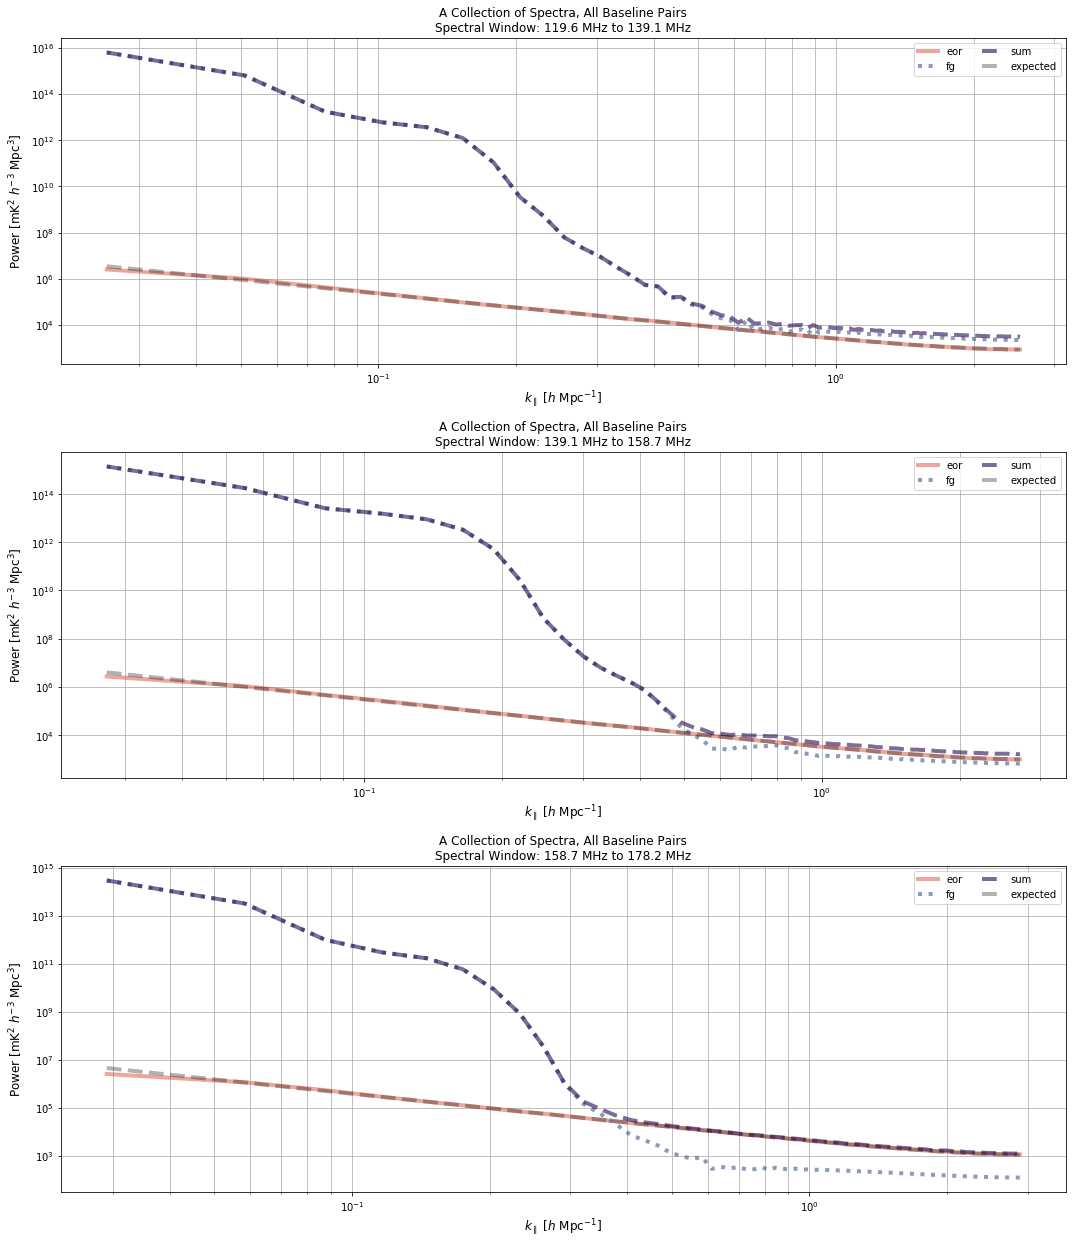

In [31]:
plot_avg_spectra(spectra_avg, aliased_spectra);

**Figure 2** | Power spectra for the three spectral windows used in this analysis. Only auto-baseline pairs were used for power spectrum estimation. Each line notes the power spectrum estimate, incoherently averaged in time over the full eight hours of simulated data used and averaged over all baseline pairs. We only see EoR dominate the signal at some $k$-modes in the upper spectral window. 

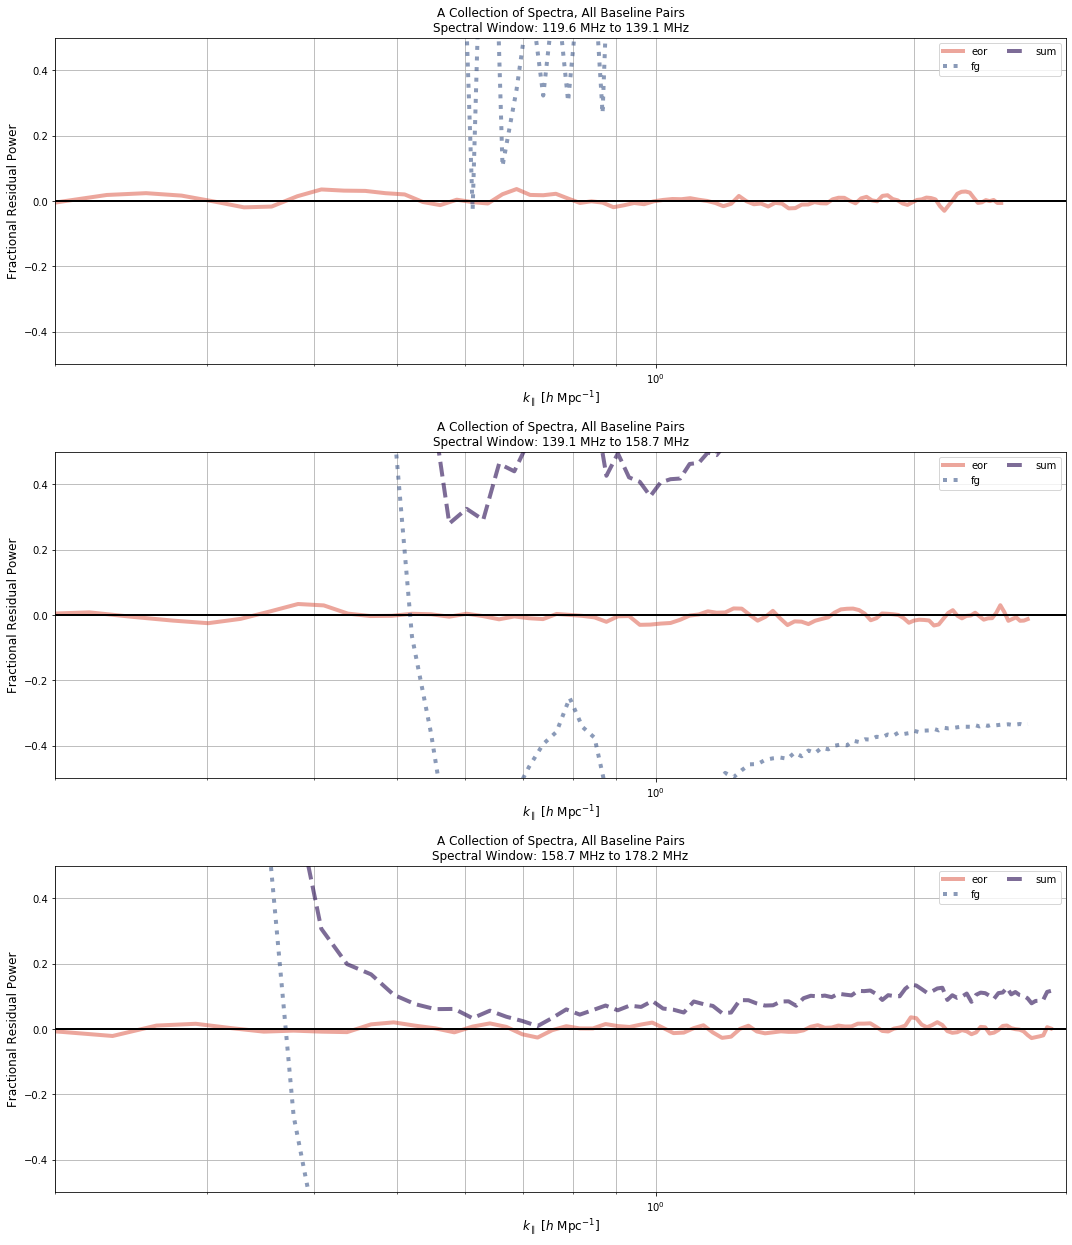

In [32]:
# Plot residual
plot_avg_spectra(spectra_avg, aliased_spectra, resid=True, xlim=(0.2, 3), ylim=(-0.5, 0.5))

**Figure 3** | Fractional residuals, measured relative to the analytic power spectrum. Note that at low frequencies, the EoR is too weak to be detected at any $k_{||}$. At higher frequencies, the estimate of the spectrum of the sum conforms both to the analytic power and the eor power (i.e. foreground power is not being thrown out to arbitrarily high $k_{||}$). 